In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [2]:
#load data
data = pd.read_csv("fold_3_data.txt",sep = "\t" )
data1 = pd.read_csv("fold_1_data.txt",sep = "\t")
data2 = pd.read_csv("fold_2_data.txt",sep = "\t")
data3 = pd.read_csv("fold_0_data.txt",sep = "\t")
data4 = pd.read_csv("fold_4_data.txt",sep = "\t")


In [3]:
#gathring the data
total_data = pd.concat([data, data1, data2, data3, data4], ignore_index=True)
print(data.shape)
print(data1.shape)
print(data2.shape)
print(data3.shape)
print(data4.shape)
print(total_data.shape)

(3446, 12)
(3730, 12)
(3894, 12)
(4484, 12)
(3816, 12)
(19370, 12)


In [4]:
#present data
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,113445054@N07,11763777465_11d01c34ce_o.jpg,1322,"(25, 32)",m,1102,296,357,357,-15,0,59
1,113445054@N07,11763777465_11d01c34ce_o.jpg,1323,"(25, 32)",f,1713,580,325,325,-5,0,118
2,113445054@N07,11763777465_11d01c34ce_o.jpg,1324,"(15, 20)",f,1437,664,306,306,5,0,109
3,113445054@N07,11764005785_f21921aea6_o.jpg,1325,"(25, 32)",f,978,229,803,803,-20,-45,16
4,113445054@N07,11763728674_a41d99f71e_o.jpg,1326,"(25, 32)",m,1745,910,242,242,-10,0,55


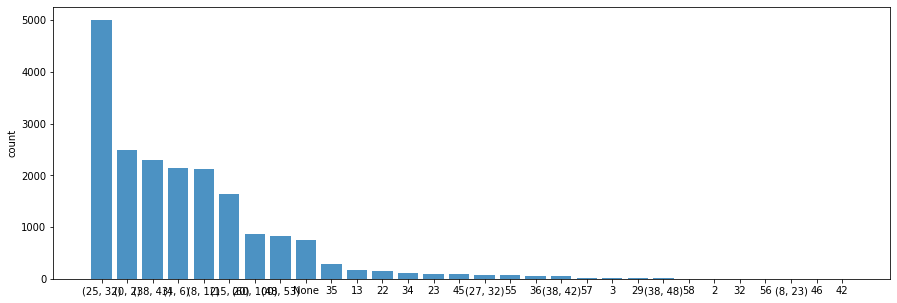

(25, 32)     5004
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2124
(15, 20)     1642
(60, 100)     872
(48, 53)      830
None          748
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
57             24
3              18
29             11
(38, 48)        6
58              5
32              3
2               3
56              2
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

In [5]:
#bar chart to present age

age = ['(25, 32)' , '(0, 2)', '(38, 43)' ,'(4, 6) ','(8, 12)','(15, 20)','(60, 100)','(48, 53)' ,'None','35','13','22','34','23' ,'45','(27, 32)','55','36','(38, 42)','57','3','29','(38, 48)','58','2','32','56','(8, 23)','46','42']

plt.figure(figsize=(15, 5))  # width:20, height:3
plt.bar(age, total_data.age.value_counts(), align='center', alpha=0.8)
plt.ylabel('count')
plt.show()
#to Create horizontal bar plot here "plt.barh(labels, values)"

total_data.age.value_counts()

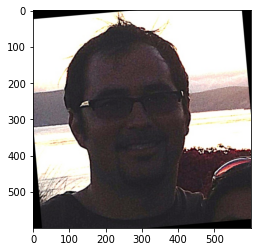

In [6]:
#present image from the dataset
path = "faces/"+total_data.user_id.loc[8]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[8])+"."+total_data.original_image.loc[8]
img = load_img(path)
plt.imshow(img)
plt.show()

In [7]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()

In [8]:
img_path = []
for row in total_data.iterrows():
    path = "faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [9]:
#present data befor
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",m,1102,296,357,357,faces/113445054@N07/coarse_tilt_aligned_face.1...
1,"(25, 32)",f,1713,580,325,325,faces/113445054@N07/coarse_tilt_aligned_face.1...
2,"(15, 20)",f,1437,664,306,306,faces/113445054@N07/coarse_tilt_aligned_face.1...
3,"(25, 32)",f,978,229,803,803,faces/113445054@N07/coarse_tilt_aligned_face.1...
4,"(25, 32)",m,1745,910,242,242,faces/113445054@N07/coarse_tilt_aligned_face.1...


In [10]:
#correlation
corr = df.corr()
corr

,x,y,dx,dy
x,1.000000,0.343700,-0.279544,-0.280495
y,0.343700,1.000000,-0.296527,-0.293110
dx,-0.279544,-0.296527,1.000000,0.991960
dy,-0.280495,-0.293110,0.991960,1.000000


In [11]:
#mapping ages
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

        
#drop none values in age        
df = df.drop(labels=drop_labels, axis=0) #droped None values
#df.age.value_counts(dropna=False)


#drop none gender values(u)  
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
#unbiased_data.info()

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
#labeling gender
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

#labeling age
age_to_label_map = {
    '0-2'  :0,
    '4-6'  :1,
    '8-13' :2,
    '15-20':3,
    '25-32':4,
    '38-43':5,
    '48-53':6,
    '60+'  :7
}

label_to_age_map = {value: key for key, value in age_to_label_map.items()}
label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

In [13]:
#change age and gender to labels
unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])

unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,1,1102,296,357,357,faces/113445054@N07/coarse_tilt_aligned_face.1...
1,4,0,1713,580,325,325,faces/113445054@N07/coarse_tilt_aligned_face.1...
2,3,0,1437,664,306,306,faces/113445054@N07/coarse_tilt_aligned_face.1...
3,4,0,978,229,803,803,faces/113445054@N07/coarse_tilt_aligned_face.1...
4,4,1,1745,910,242,242,faces/113445054@N07/coarse_tilt_aligned_face.1...


#### Plot random image with its size, gender and age¶

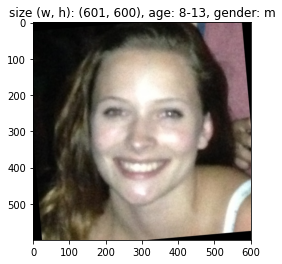

In [14]:
#to plot image
def show_image(img_filename, age, gender):
    img = Image.open(img_filename)
    plt.imshow(img)
    plt.title(f'size (w, h): {img.size}, age: {age}, gender: {gender}')
    plt.show()
    
idx = np.random.randint(unbiased_data.shape[0])
fname = unbiased_data['img_path'].iloc[idx]
age = label_to_age_map[unbiased_data['age'][idx]]
gender = label_to_gender_map[unbiased_data['gender'][idx]]
show_image(fname, age, gender)

# Model


##### Gender Classification

In [15]:
#splitting dataset
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [18]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


In [20]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=(2, 2), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=2, activation='softmax'))

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 111, 111, 96)      14208     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 96)        0         
_________________________________________________________________
layer_normalization_3 (Layer (None, 55, 55, 96)        192       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 55, 55, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
layer_normalization_4 (Layer (None, 27, 27, 256)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 27, 256)      

In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs=1
history = model.fit(train_images, y_train, batch_size=32,  epochs=epochs, validation_data=(test_images, y_test), callbacks=[callback])

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


382/382 [==============================] - 2064s 5s/step - loss: 0.6909 - accuracy: 0.5351 - val_loss: 0.6909 - val_accuracy: 0.5338


In [25]:
#save history
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)    

In [26]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print('Testing accuracy',test_acc)

164/164 - 232s - loss: 0.6909 - accuracy: 0.5338
Testing accuracy 0.5338044166564941


In [27]:
train_acc = model.evaluate(train_images, y_train)
print('Training accuracy',train_acc)

382/382 [==============================] - 584s 2s/step - loss: 0.6907 - accuracy: 0.5351
Training accuracy [0.6907141804695129, 0.5351178646087646]


# Predection gender (0:f, 1:m)

In [28]:
#predection
model.predict(test_images[:4])
#test_images[:4]
y_test[:4]

,gender
16807,1
1395,1
2362,0
19,1


In [29]:
from sklearn.metrics import confusion_matrix
pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [30]:
from sklearn.metrics import classification_report
CM=classification_report(y_true, pred)
print(CM)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5236

    accuracy                           1.00      5236
   macro avg       1.00      1.00      1.00      5236
weighted avg       1.00      1.00      1.00      5236



In [31]:
from sklearn.metrics import r2_score
print('R2 score for gender: ', r2_score(y_true, pred))

R2 score for gender:  1.0


In [36]:
#visualaze cnn model
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


# Age classification

In [37]:
#splitting dataset
X = unbiased_data[['img_path']]
y = unbiased_data[['age']]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [38]:
train_images = []
test_images = []

for row in X_train.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    train_images.append(data)

for row in X_test.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (5236, 227, 227, 3)


In [39]:
model = Sequential()
model.add(Conv2D(input_shape=(227, 227, 3), filters=96, kernel_size=(7, 7), strides=4, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(LayerNormalization())

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=8, activation='softmax'))

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3) # Callback for earlystopping

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs=1
history = model.fit(train_images, y_train, batch_size=32, epochs=epochs, validation_data=(test_images, y_test), callbacks=[callback])

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


382/382 [==============================] - ETA: 0s - loss: 2.1568 - accuracy: 0.2831

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


382/382 [==============================] - 674s 2s/step - loss: 2.1568 - accuracy: 0.2831 - val_loss: 1.9153 - val_accuracy: 0.3065


In [42]:
#save history
with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [43]:
test_loss, test_acc = model.evaluate(test_images, y_test, verbose=2)
print('Testing accuracy',test_acc)

164/164 - 64s - loss: 1.9153 - accuracy: 0.3065
Testing accuracy 0.306531697511673


In [44]:
train_acc =model.evaluate(train_images, y_train)
print('Training accuracy',train_acc)

382/382 [==============================] - 166s 435ms/step - loss: 1.9241 - accuracy: 0.2976
Training accuracy [1.9240671396255493, 0.29756057262420654]


###  Predection age ('0-2':0, '4-6':1, '8-13':2, '15-20':3, '25-32':4, '38-43':5, '48-53':6, '60+':7)

In [45]:
#predection
model.predict(test_images[:4])
#test_images[:4]
y_test[:4]

,age
16807,1
1395,3
2362,3
19,4


In [46]:
from sklearn.metrics import confusion_matrix
pred2 = model.predict(test_images)
pred2 = np.argmax(pred2,axis = 1) 
y_true2 = np.argmax(y_test,axis = 1)

In [47]:
from sklearn.metrics import classification_report
CM2=classification_report(y_true2, pred2)
print(CM2)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    5236.0
           4       0.00      0.00      0.00       0.0

    accuracy                           0.00    5236.0
   macro avg       0.00      0.00      0.00    5236.0
weighted avg       0.00      0.00      0.00    5236.0



c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [48]:
from sklearn.metrics import r2_score
print('R2 score for age: ', r2_score(y_true2, pred2))

R2 score for age:  0.0


In [49]:
callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None ) # Callback for TensorBoard

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_images, y_train, batch_size=32,  epochs=epochs, validation_data=(test_images, y_test), callbacks=[callback])

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


382/382 [==============================] - ETA: 0s - loss: 1.9258 - accuracy: 0.2976

c:\users\ravi\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


382/382 [==============================] - 592s 2s/step - loss: 1.9258 - accuracy: 0.2976 - val_loss: 1.9175 - val_accuracy: 0.3065
